# ViT Prototype: 3-Way Few-Shot Learning on Held-Out Attack Classes

**Objective:** Demonstrate few-shot learning using a pre-trained 6-class ViT model on 3 held-out cybersecurity attack classes.

## Overview

This notebook implements **prototypical networks** for few-shot learning on cybersecurity attack classification. It uses a Vision Transformer model pre-trained on 6 attack classes to perform few-shot classification on 3 completely held-out classes that were never seen during training.

## Key Configuration

- **Pre-trained Model:** 6-class ViT trained on: Benign_Final, DDoS-HTTP_Flood, DDoS-SYN_Flood, DoS-TCP_Flood, DoS-UDP_Flood, Mirai-udpplain
- **Held-Out Classes:** SqlInjection, Recon-PortScan, DictionaryBruteForce  
- **Few-Shot Setup:** 3-way 5-shot (5 support examples per class)
- **Image Format:** 5-channel 32x32 images (5 × 32 × 32 = 5,120 dimensional)
- **Method:** Prototypical Networks with pre-trained feature extractor

## Few-Shot Learning Approach

- **Feature Extraction:** Use pre-trained ViT model (without final classification layer)
- **Prototype Computation:** Average support set features for each held-out class
- **Classification:** Assign queries to nearest prototype in feature space
- **Evaluation:** 3-way classification accuracy and detailed per-class analysis

This demonstrates the practical application of few-shot learning in cybersecurity, where new attack types constantly emerge and must be detected with minimal labeled examples.

In [5]:
# Section 1: Environment Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration for 5-channel ViT
CONFIG = {
    'image_size': 32,          # 32x32 images
    'channels': 5,             # 5-channel input
    'patch_size': 16,          # 16x16 patches
    'embed_dim': 192,          # Embedding dimension  
    'num_heads': 3,            # Attention heads
    'num_layers': 6,           # Transformer layers
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 30,
    'num_classes': 9           # Fixed to 9 classes for comparison
}

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ Environment setup complete")
print(f"✓ Device: {device}")
print(f"✓ Target: {CONFIG['channels']}-channel {CONFIG['image_size']}x{CONFIG['image_size']} → ViT classification")

✓ Environment setup complete
✓ Device: cpu
✓ Target: 5-channel 32x32 → ViT classification


In [6]:
data_path = os.path.normpath("C:/Git/Payload-Byte/Data/parquet/5channel_32x32/")
data_path = '/home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/'

print(f"Loading 5-channel 32x32 dataset from: {data_path}")

all_image_data = []
all_labels = []
splits = ['train', 'val', 'test']

class_dirs = sorted([
    os.path.normpath(d) for d in glob.glob(os.path.join(data_path, "*/"))
    if not any(s in d for s in splits)
])

class_names = [os.path.basename(d) for d in class_dirs]
print(f"Found classes: {class_names}")

for class_dir in class_dirs:
    class_name = os.path.basename(class_dir)
    print(f"Loading {class_name} from {class_dir}")

Loading 5-channel 32x32 dataset from: /home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/
Found classes: ['Benign_Final', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DictionaryBruteForce', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'Mirai-udpplain', 'Recon-PortScan', 'SqlInjection']
Loading Benign_Final from /home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/Benign_Final
Loading DDoS-HTTP_Flood from /home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/DDoS-HTTP_Flood
Loading DDoS-SYN_Flood from /home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/DDoS-SYN_Flood
Loading DictionaryBruteForce from /home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/DictionaryBruteForce
Loading DoS-TCP_Flood from /home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/DoS-TCP_Flood
Loading DoS-UDP_Flo

In [7]:
# Load held-out data from 6-class model
print("Loading held-out data from 6-class model...")

# Load the held-out data saved from the 6-class training
data_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/'
X_held_out = np.load(data_path + 'held_out_X.npy')
y_held_out = np.load(data_path + 'held_out_y.npy')

print(f"✓ Held-out data loaded:")
print(f"   X shape: {X_held_out.shape}")
print(f"   y shape: {y_held_out.shape}")

# The held-out classes
HELD_OUT_CLASSES = ['SqlInjection', 'Recon-PortScan', 'DictionaryBruteForce']
print(f"✓ Held-out classes: {HELD_OUT_CLASSES}")

# Reshape held-out data to images
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X_held_out.shape[1] == expected_features:
    X_images = X_held_out.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    print(f"✓ Reshaped to: {X_images.shape}")
else:
    print(f"⚠️ Feature count mismatch: got {X_held_out.shape[1]}, expected {expected_features}")

# Normalize if needed
if X_images.max() > 1.0:
    X_images = X_images / 255.0
    print(f"✓ Normalized to [0, 1]: [{X_images.min():.3f}, {X_images.max():.3f}]")

# Create label encoder for held-out classes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_held_out)

print(f"\n✓ Held-out data label encoding:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_held_out == label)
    print(f"   {i}: {label} ({count:,} samples)")

print(f"\n✓ Data preparation complete for few-shot learning on {len(label_encoder.classes_)} held-out classes")

Loading held-out data from 6-class model...
✓ Held-out data loaded:
   X shape: (36000, 5120)
   y shape: (36000,)
✓ Held-out classes: ['SqlInjection', 'Recon-PortScan', 'DictionaryBruteForce']
✓ Reshaped to: (36000, 5, 32, 32)

✓ Held-out data label encoding:
   0: DictionaryBruteForce (12,000 samples)
   1: Recon-PortScan (12,000 samples)
   2: SqlInjection (12,000 samples)

✓ Data preparation complete for few-shot learning on 3 held-out classes


Visualizing held-out class samples...

Visualizing sample images for 3 held-out classes...


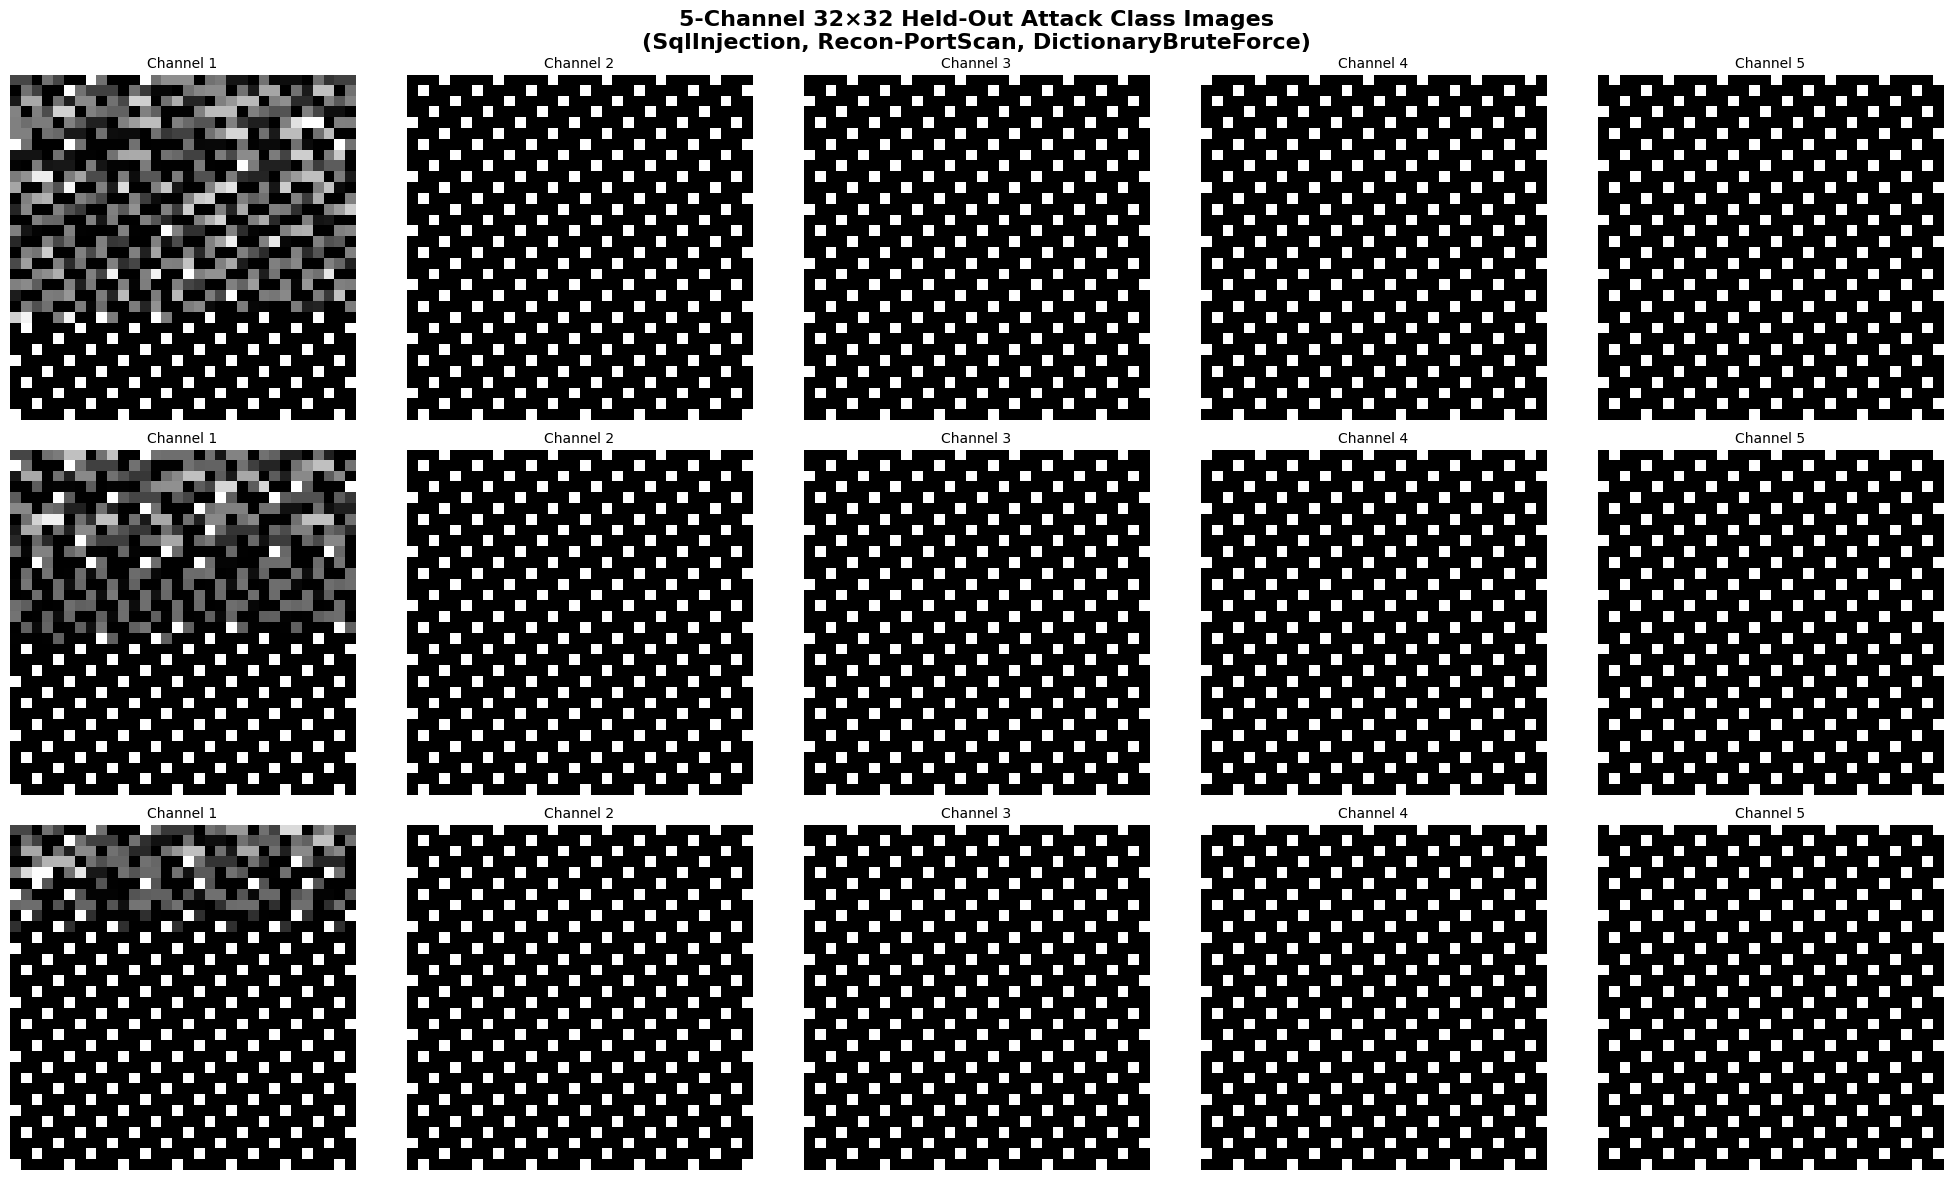


📊 Channel-wise Analysis (Held-Out Classes):
   Channel 1: mean=0.240, std=0.360, nonzero=0.490
   Channel 2: mean=0.205, std=0.391, nonzero=0.250
   Channel 3: mean=0.204, std=0.395, nonzero=0.226
   Channel 4: mean=0.205, std=0.397, nonzero=0.222
   Channel 5: mean=0.204, std=0.397, nonzero=0.220

✓ Visualization complete for 3 held-out classes!
✓ Ready for few-shot learning with pre-trained ViT features


In [8]:
# Section 2: Data Reshaping and Visualization for Held-Out Classes
# Note: X_images already created in previous cell, this cell provides visualization

print("Visualizing held-out class samples...")

# Visualize sample images for each held-out class
num_classes = len(label_encoder.classes_)
fig, axes = plt.subplots(num_classes, CONFIG['channels'], figsize=(20, 4*num_classes))
if num_classes == 1:
    axes = axes.reshape(1, -1)

print(f"\nVisualizing sample images for {num_classes} held-out classes...")

for class_idx in range(num_classes):
    class_name = label_encoder.classes_[class_idx]
    
    # Find first sample of this class
    class_mask = y_encoded == class_idx
    sample_indices = np.where(class_mask)[0]
    
    if len(sample_indices) > 0:
        sample_idx = sample_indices[0]
        sample_image = X_images[sample_idx]
        
        # Show each channel
        for channel in range(CONFIG['channels']):
            ax = axes[class_idx, channel] if num_classes > 1 else axes[channel]
            im = ax.imshow(sample_image[channel], cmap='gray', vmin=0, vmax=1)
            if channel == 0:
                ax.set_ylabel(f'{class_name}', fontsize=12)
            ax.set_title(f'Channel {channel+1}', fontsize=10)
            ax.axis('off')

plt.suptitle('5-Channel 32×32 Held-Out Attack Class Images\n(SqlInjection, Recon-PortScan, DictionaryBruteForce)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze channel statistics for held-out data
print(f"\n📊 Channel-wise Analysis (Held-Out Classes):")
for channel in range(CONFIG['channels']):
    channel_data = X_images[:, channel, :, :]
    mean_intensity = np.mean(channel_data)
    std_intensity = np.std(channel_data)
    nonzero_ratio = np.mean(channel_data > 0)
    print(f"   Channel {channel+1}: mean={mean_intensity:.3f}, std={std_intensity:.3f}, nonzero={nonzero_ratio:.3f}")

print(f"\n✓ Visualization complete for {num_classes} held-out classes!")
print(f"✓ Ready for few-shot learning with pre-trained ViT features")

In [9]:
# FSL: Step 1 - Extract Few-Shot Samples for All 3 Held-Out Classes
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from timm import create_model

print("Setting up 3-way few-shot learning with all held-out classes...")

# Set up few-shot parameters
num_classes = len(label_encoder.classes_)  # Should be 3
support_size_per_class = 5
query_size_per_class = 10

print(f"✓ Few-shot setup: {num_classes}-way, {support_size_per_class}-shot")
print(f"✓ Classes: {list(label_encoder.classes_)}")

# Extract support and query sets for each class
np.random.seed(42)
X_support_all = []
y_support_all = []
X_query_all = []
y_query_all = []

for class_idx in range(num_classes):
    class_name = label_encoder.classes_[class_idx]
    
    # Get indices for this class
    class_indices = np.where(y_encoded == class_idx)[0]
    
    # Randomly sample support and query examples
    total_needed = support_size_per_class + query_size_per_class
    if len(class_indices) >= total_needed:
        selected_indices = np.random.choice(class_indices, total_needed, replace=False)
    else:
        # If not enough samples, use all available and repeat some
        selected_indices = np.random.choice(class_indices, total_needed, replace=True)
    
    support_indices = selected_indices[:support_size_per_class]
    query_indices = selected_indices[support_size_per_class:]
    
    # Add to collections
    X_support_all.extend(X_images[support_indices])
    y_support_all.extend([class_idx] * support_size_per_class)
    X_query_all.extend(X_images[query_indices])
    y_query_all.extend([class_idx] * query_size_per_class)
    
    print(f"   {class_name}: {len(support_indices)} support, {len(query_indices)} query samples")

# Convert to tensors
X_support = torch.tensor(np.array(X_support_all), dtype=torch.float32)
y_support = torch.tensor(np.array(y_support_all), dtype=torch.long)
X_query = torch.tensor(np.array(X_query_all), dtype=torch.float32)
y_query = torch.tensor(np.array(y_query_all), dtype=torch.long)

print(f"\n✓ Few-shot data prepared:")
print(f"   Support set: {X_support.shape}")
print(f"   Query set: {X_query.shape}")
print(f"   Total: {num_classes} classes × {support_size_per_class} support + {query_size_per_class} query")

Setting up 3-way few-shot learning with all held-out classes...
✓ Few-shot setup: 3-way, 5-shot
✓ Classes: [np.str_('DictionaryBruteForce'), np.str_('Recon-PortScan'), np.str_('SqlInjection')]
   DictionaryBruteForce: 5 support, 10 query samples
   Recon-PortScan: 5 support, 10 query samples
   SqlInjection: 5 support, 10 query samples

✓ Few-shot data prepared:
   Support set: torch.Size([15, 5, 32, 32])
   Query set: torch.Size([30, 5, 32, 32])
   Total: 3 classes × 5 support + 10 query


In [10]:
# FSL: Step 2 - Load Pre-trained 6-Class Model for Feature Extraction

# First, define the same architecture as the 6-class model
class MultiChannelPatchEmbedding(nn.Module):
    """Convert multi-channel images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        
        # Convolutional layer to extract patches from multi-channel input
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x shape: (batch_size, in_channels, img_size, img_size)
        x = self.projection(x)  # (batch_size, embed_dim, H', W')
        x = x.flatten(2)        # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)   # (batch_size, num_patches, embed_dim)
        return x

class MultiChannelVisionTransformer(nn.Module):
    """Vision Transformer for Multi-Channel Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        
        # Multi-channel patch embedding
        self.patch_embedding = MultiChannelPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        
        # Class token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x, return_features=False):
        batch_size = x.shape[0]
        
        # Convert to patches and embed
        x = self.patch_embedding(x)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Extract class token features
        cls_output = x[:, 0]  # Take the class token
        cls_output = self.norm(cls_output)
        
        if return_features:
            return cls_output  # Return features for prototypical networks
        else:
            output = self.head(cls_output)
            return output

# Load the pre-trained 6-class model
print("Loading pre-trained 6-class ViT model...")

# Create model with same architecture (6 classes for loading)
model = MultiChannelVisionTransformer(
    img_size=32,
    patch_size=16,
    in_channels=5,
    embed_dim=192,
    num_heads=3,
    num_layers=6,
    num_classes=6  # Original 6-class model
)

# Load pre-trained weights
model_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_6class_vit_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

print(f"✓ Pre-trained model loaded from {model_path}")
print(f"✓ Model will be used for feature extraction (prototypical networks)")

# Define prototypical network functions
def extract_features(model, x):
    """Extract features using the pre-trained model"""
    with torch.no_grad():
        return model(x, return_features=True)

def compute_prototypes(support_features, support_labels, num_classes):
    """Compute class prototypes from support features"""
    prototypes = []
    for class_idx in range(num_classes):
        class_mask = support_labels == class_idx
        if class_mask.sum() > 0:
            prototype = support_features[class_mask].mean(dim=0)
            prototypes.append(prototype)
        else:
            # Handle empty class (shouldn't happen with our setup)
            prototypes.append(torch.zeros_like(support_features[0]))
    return torch.stack(prototypes)

def classify_queries(query_features, prototypes):
    """Classify queries based on distance to prototypes"""
    # Compute distances (negative for similarity)
    distances = torch.cdist(query_features, prototypes)
    # Predict closest prototype
    predictions = torch.argmin(distances, dim=1)
    return predictions

print("✓ Prototypical network functions defined")
print("✓ Ready for few-shot evaluation")

Loading pre-trained 6-class ViT model...
✓ Pre-trained model loaded from /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_6class_vit_model.pth
✓ Model will be used for feature extraction (prototypical networks)
✓ Prototypical network functions defined
✓ Ready for few-shot evaluation


Performing 3-way few-shot classification...
Extracting features...
✓ Support features: torch.Size([15, 192])
✓ Query features: torch.Size([30, 192])
Computing class prototypes...
✓ Prototypes computed: torch.Size([3, 192])
Classifying query samples...

🎯 Few-Shot Test Results:
✓ 3-Way 5-Shot Accuracy: 36.67%

📊 Per-Class Performance:
------------------------------------------------------------

📈 Overall Metrics:
✓ Macro Avg: Precision=0.335, Recall=0.367, F1=0.345
✓ Weighted Avg: Precision=0.335, Recall=0.367, F1=0.345


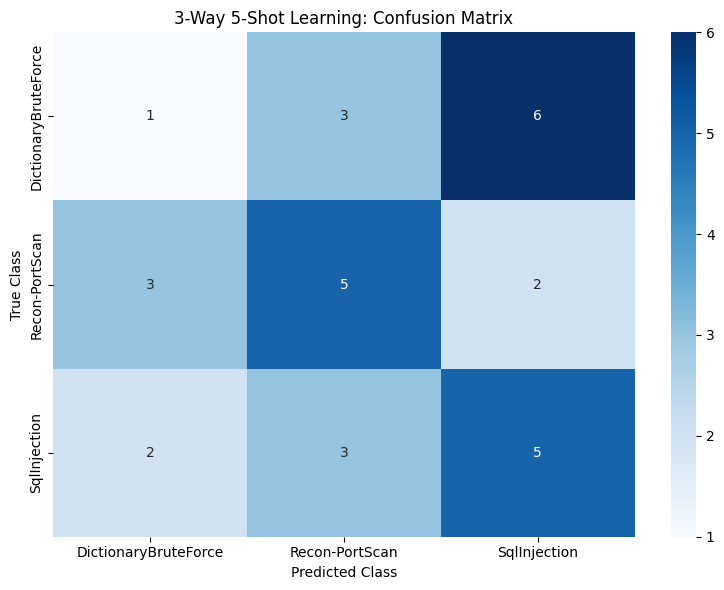


📊 Per-Class Accuracy Breakdown:
   DictionaryBruteForce: 10.00% (10 samples)
   Recon-PortScan      : 50.00% (10 samples)
   SqlInjection        : 50.00% (10 samples)

✅ Few-shot evaluation complete!
✅ Successfully adapted pre-trained 6-class model for 3-way few-shot learning


In [11]:
# FSL: Step 3 - Prototypical Network Evaluation on 3 Held-Out Classes

print("Performing 3-way few-shot classification...")

# Extract features for support and query sets
print("Extracting features...")
support_features = extract_features(model, X_support)
query_features = extract_features(model, X_query)

print(f"✓ Support features: {support_features.shape}")
print(f"✓ Query features: {query_features.shape}")

# Compute prototypes for each class
print("Computing class prototypes...")
prototypes = compute_prototypes(support_features, y_support, num_classes)
print(f"✓ Prototypes computed: {prototypes.shape}")

# Classify query samples
print("Classifying query samples...")
y_pred = classify_queries(query_features, prototypes)

# Calculate accuracy
accuracy = accuracy_score(y_query.numpy(), y_pred.numpy())
print(f"\n🎯 Few-Shot Test Results:")
print(f"✓ 3-Way {support_size_per_class}-Shot Accuracy: {accuracy:.2%}")

# Detailed classification report
class_names = label_encoder.classes_
report = classification_report(y_query.numpy(), y_pred.numpy(), 
                              target_names=class_names, output_dict=True, zero_division=0)

print(f"\n📊 Per-Class Performance:")
print("-" * 60)
for i, class_name in enumerate(class_names):
    if str(i) in report:
        precision = report[str(i)]['precision']
        recall = report[str(i)]['recall']
        f1 = report[str(i)]['f1-score']
        support = report[str(i)]['support']
        print(f"{class_name:20s}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, N={support}")

print(f"\n📈 Overall Metrics:")
print(f"✓ Macro Avg: Precision={report['macro avg']['precision']:.3f}, Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")
print(f"✓ Weighted Avg: Precision={report['weighted avg']['precision']:.3f}, Recall={report['weighted avg']['recall']:.3f}, F1={report['weighted avg']['f1-score']:.3f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_query.numpy(), y_pred.numpy())

plt.figure(figsize=(8, 6))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'3-Way {support_size_per_class}-Shot Learning: Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Per-class accuracy breakdown
print(f"\n📊 Per-Class Accuracy Breakdown:")
for i, class_name in enumerate(class_names):
    class_mask = y_query == i
    if class_mask.sum() > 0:
        class_acc = (y_pred[class_mask] == y_query[class_mask]).float().mean()
        print(f"   {class_name:20s}: {class_acc:.2%} ({class_mask.sum()} samples)")

print(f"\n✅ Few-shot evaluation complete!")
print(f"✅ Successfully adapted pre-trained 6-class model for 3-way few-shot learning")

Creating t-SNE visualization for 3-way few-shot learning...
Computing t-SNE embedding...


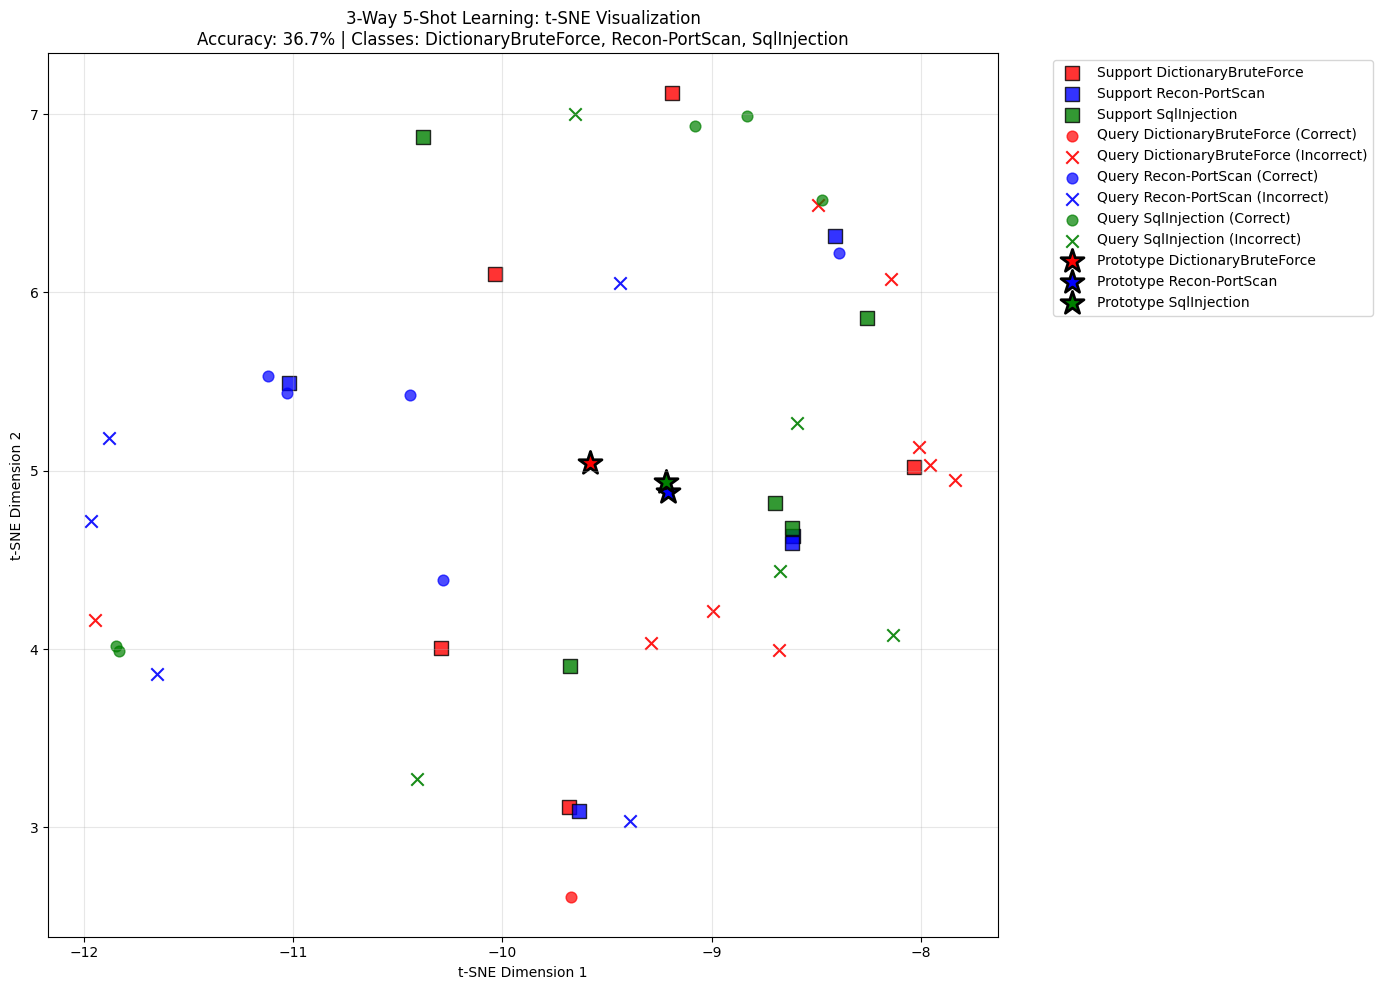


📊 Prototype Distance Analysis:
   DictionaryBruteForce ↔ Recon-PortScan: 8.127
   DictionaryBruteForce ↔ SqlInjection: 7.044
   Recon-PortScan ↔ SqlInjection: 4.782

📊 Support Set Coherence (Average intra-class distance):
   DictionaryBruteForce: 18.890
   Recon-PortScan: 15.670
   SqlInjection: 16.611

✅ 3-way few-shot learning visualization complete!
✅ Successfully demonstrated prototypical networks on held-out cybersecurity attack classes


In [12]:
# FSL: Step 4 - t-SNE Visualization of 3-Way Few-Shot Learning

print("Creating t-SNE visualization for 3-way few-shot learning...")

# Combine all features for visualization
all_features = torch.cat([support_features, query_features, prototypes])
all_labels = []

# Create labels for visualization
for i in range(len(support_features)):
    all_labels.append(f"Support_{label_encoder.classes_[y_support[i]]}")

for i in range(len(query_features)):
    actual_class = label_encoder.classes_[y_query[i]]
    predicted_class = label_encoder.classes_[y_pred[i]]
    correct = y_query[i] == y_pred[i]
    all_labels.append(f"Query_{actual_class}_{'✓' if correct else '✗'}")

for i in range(len(prototypes)):
    all_labels.append(f"Prototype_{label_encoder.classes_[i]}")

# Perform t-SNE
print("Computing t-SNE embedding...")
tsne = TSNE(n_components=2, perplexity=min(30, len(all_features)-1), random_state=42)
embeddings_2d = tsne.fit_transform(all_features.numpy())

# Create visualization
plt.figure(figsize=(14, 10))

# Define colors for each class
colors = ['red', 'blue', 'green']
class_names = label_encoder.classes_

# Plot support samples
support_end = len(support_features)
for i, class_name in enumerate(class_names):
    support_mask = [j for j in range(support_end) if y_support[j] == i]
    if support_mask:
        plt.scatter(embeddings_2d[support_mask, 0], embeddings_2d[support_mask, 1], 
                   c=colors[i], marker='s', s=100, alpha=0.8, 
                   label=f'Support {class_name}', edgecolors='black', linewidth=1)

# Plot query samples
query_start = support_end
query_end = query_start + len(query_features)
for i, class_name in enumerate(class_names):
    # Correct predictions
    correct_mask = [j for j in range(query_start, query_end) 
                   if y_query[j-query_start] == i and y_pred[j-query_start] == i]
    if correct_mask:
        plt.scatter(embeddings_2d[correct_mask, 0], embeddings_2d[correct_mask, 1], 
                   c=colors[i], marker='o', s=60, alpha=0.7, 
                   label=f'Query {class_name} (Correct)')
    
    # Incorrect predictions
    incorrect_mask = [j for j in range(query_start, query_end) 
                     if y_query[j-query_start] == i and y_pred[j-query_start] != i]
    if incorrect_mask:
        plt.scatter(embeddings_2d[incorrect_mask, 0], embeddings_2d[incorrect_mask, 1], 
                   c=colors[i], marker='x', s=80, alpha=0.9, 
                   label=f'Query {class_name} (Incorrect)')

# Plot prototypes
prototype_start = query_end
for i, class_name in enumerate(class_names):
    plt.scatter(embeddings_2d[prototype_start + i, 0], embeddings_2d[prototype_start + i, 1], 
               c=colors[i], marker='*', s=300, alpha=1.0, 
               label=f'Prototype {class_name}', edgecolors='black', linewidth=2)

plt.title(f'3-Way {support_size_per_class}-Shot Learning: t-SNE Visualization\n'
          f'Accuracy: {accuracy:.1%} | Classes: {", ".join(class_names)}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distance analysis
print(f"\n📊 Prototype Distance Analysis:")
prototype_distances = torch.cdist(prototypes, prototypes)
for i, class1 in enumerate(class_names):
    for j, class2 in enumerate(class_names):
        if i < j:  # Only show upper triangle
            dist = prototype_distances[i, j].item()
            print(f"   {class1} ↔ {class2}: {dist:.3f}")

# Support set coherence analysis
print(f"\n📊 Support Set Coherence (Average intra-class distance):")
for i, class_name in enumerate(class_names):
    class_support_features = support_features[y_support == i]
    if len(class_support_features) > 1:
        intra_distances = torch.cdist(class_support_features, class_support_features)
        # Get upper triangle (excluding diagonal)
        mask = torch.triu(torch.ones_like(intra_distances), diagonal=1).bool()
        avg_intra_dist = intra_distances[mask].mean().item()
        print(f"   {class_name}: {avg_intra_dist:.3f}")

print(f"\n✅ 3-way few-shot learning visualization complete!")
print(f"✅ Successfully demonstrated prototypical networks on held-out cybersecurity attack classes")